In [ ]:
pip install pandas numpy matplotlib seaborn scikit-learn tensorflow keras-tuner keras


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 5.2 MB/s eta 0:00:00


In [ ]:
pip install keras_tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.8 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import keras_tuner as kt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional
from statsmodels.tsa.arima.model import ARIMA
print('all files ckeck ')

all files ckeck 


In [ ]:
# Load the stock data
data = pd.read_csv('/content/drive/My Drive/tesla_monthly_clean.csv')
# print(data.head())
data['Date'] = pd.to_datetime(data['Date'])
data = data.sort_values('Date')

#resample data
monthly_data = data.resample('ME', on='Date').agg({
    'High': 'max',
    'Low': 'min',
    'Open': 'mean',
    'Close': 'last',
    'Volume': 'sum'
}).reset_index()

# drop values with nan values
monthly_data .dropna(inplace=True)

# monthly return
monthly_data['Monthly_Return'] = monthly_data['Close'].pct_change()

#Moving Averages (5, 10, 20 months)
monthly_data['MA5'] = monthly_data['Close'].rolling(window=5).mean()
monthly_data['MA10'] = monthly_data['Close'].rolling(window=10).mean()
monthly_data['MA20'] = monthly_data['Close'].rolling(window=20).mean()

# volatility
monthly_data['Volatility_3'] = monthly_data['Close'].rolling(window=3).std()

# normalizing and standarize data
features_to_scale = ['Close', 'Volume', 'Monthly_Return', 'MA5', 'MA10', 'MA20', 'Volatility_3']
scaler = StandardScaler()
monthly_data[features_to_scale] = scaler.fit_transform(monthly_data[features_to_scale])

#save the file
output_path = r'S:\Internship\project 1\tesla_monthly_clean.csv'
monthly_data.to_csv(output_path, index=False)
print("data ready")

# Load your feature-enhanced, cleaned dataset
df = pd.read_csv('/content/drive/My Drive/tesla_monthly_clean.csv')  # <-- use df instead of data
df['Date'] = pd.to_datetime(df['Date'])               # convert Date column to datetime
df = df.sort_values('Date')                           # sort by date


data ready


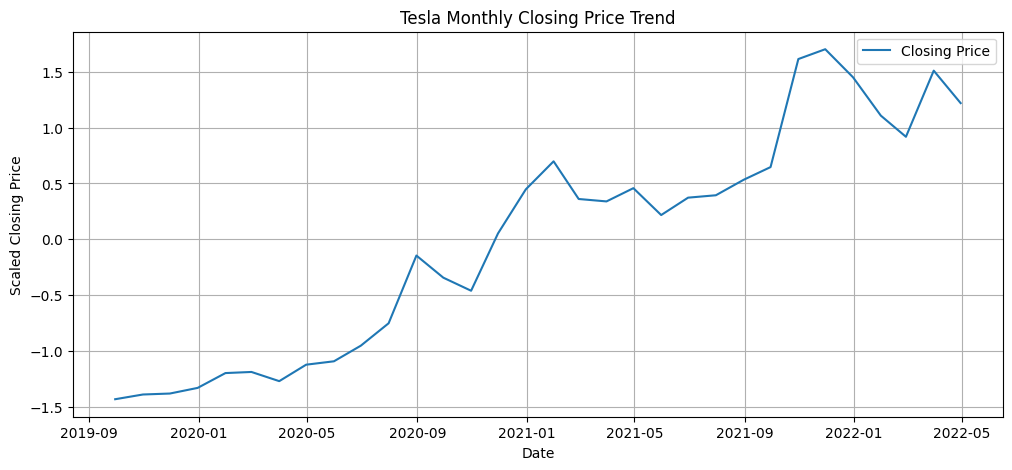

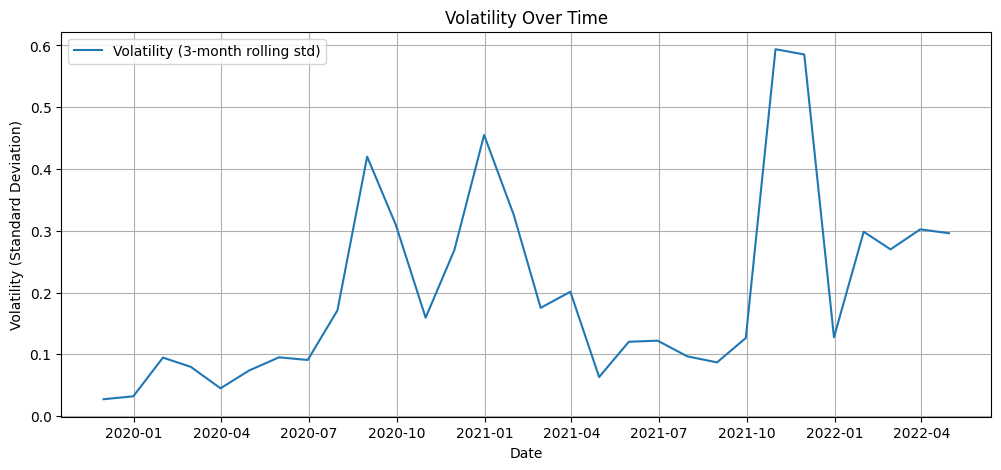

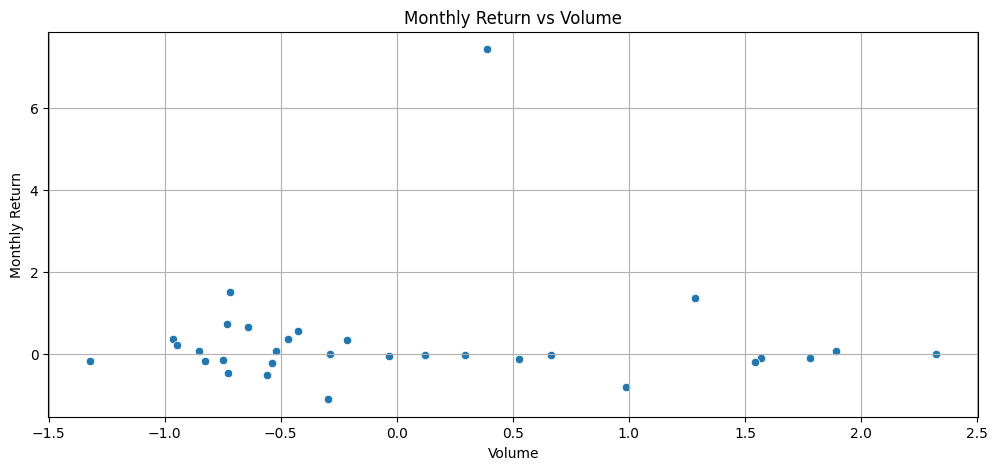

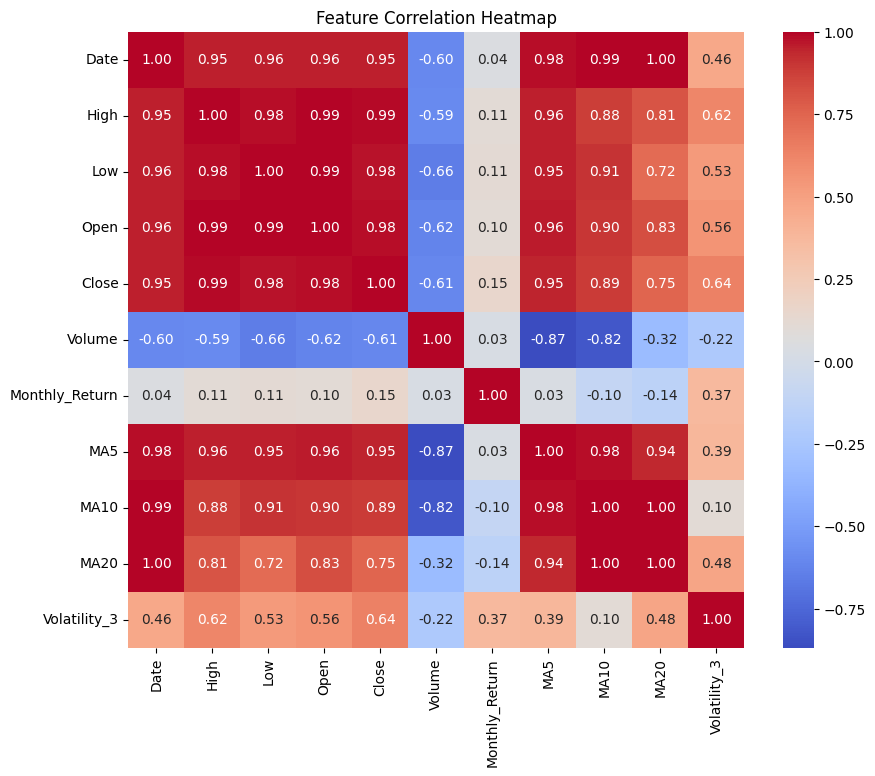

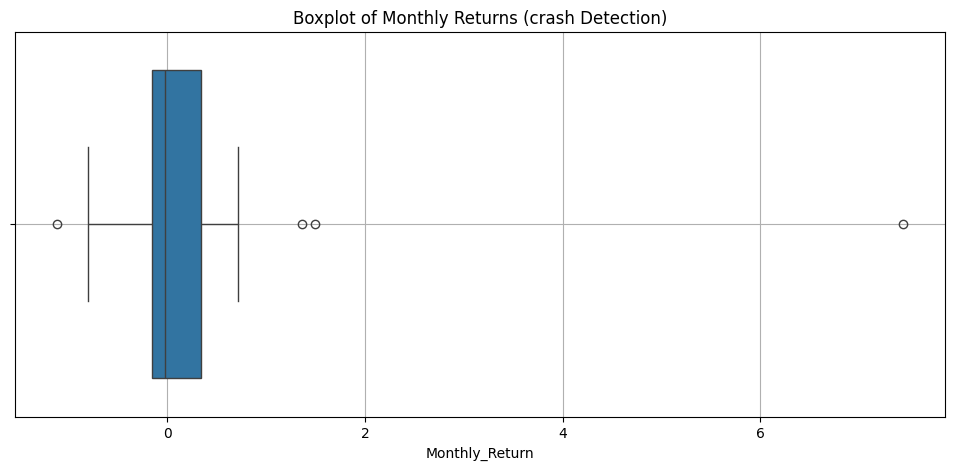

 Potential spike:
          Date  Monthly_Return
15 2020-12-31        7.440554


In [ ]:
# Closing Price Over Time
plt.figure(figsize=(12, 5))
plt.plot(df['Date'], df['Close'], label='Closing Price')
plt.title('Tesla Monthly Closing Price Trend')
plt.xlabel('Date')
plt.ylabel('Scaled Closing Price')
plt.grid(True)
plt.legend()
plt.show()

# Volatility Plot
df['Volatility_3'] = df['Close'].rolling(window=3).std()

plt.figure(figsize=(12, 5))
plt.plot(df['Date'], df['Volatility_3'], label='Volatility (3-month rolling std)')
plt.title('Volatility Over Time')
plt.xlabel('Date')
plt.ylabel('Volatility (Standard Deviation)')
plt.grid(True)
plt.legend()
plt.show()

# Volume vs Price Movement
plt.figure(figsize=(12, 5))
df['Monthly_Return'] = df['Close'].pct_change()
sns.scatterplot(x='Volume', y='Monthly_Return', data=df)
plt.title('Monthly Return vs Volume')
plt.xlabel('Volume')
plt.ylabel('Monthly Return')
plt.grid(True)
plt.show()

# Correlation Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title('Feature Correlation Heatmap')
plt.show()

# spike/crash detection
plt.figure(figsize=(12, 5))
sns.boxplot(x=df['Monthly_Return'])
plt.title('Boxplot of Monthly Returns (crash Detection)')
plt.grid(True)
plt.show()

# Large spikes detection
threshold = 2.5  # Customize threshold
outliers = df[abs(df['Monthly_Return']) > threshold]
print(" Potential spike:\n", outliers[['Date', 'Monthly_Return']])

# converting to supervised format
def create_supervised_data(df, target_col='Close', window=3):
    X, y = [], []
    for i in range(window, len(df)):
        X.append(df[target_col].values[i-window:i])
        y.append(df[target_col].values[i])
    return pd.DataFrame(X), pd.Series(y)

X, y = create_supervised_data(df, window=3)


Linear Regression MAE: 31.77
Linear Regression RMSE: 41.74


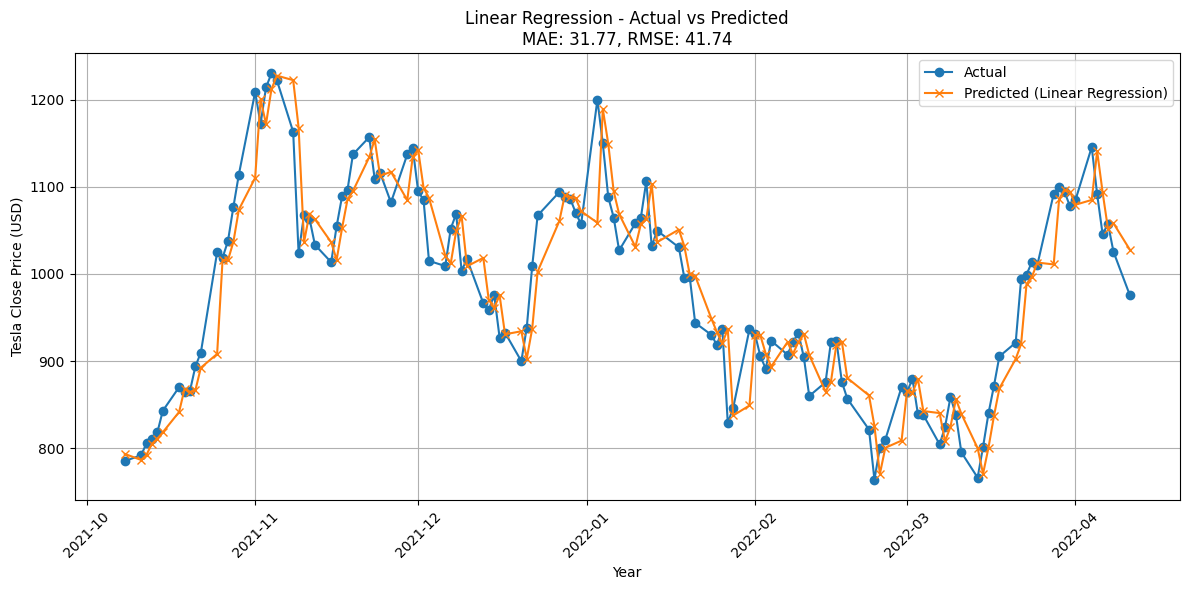

In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Load dataset
data = pd.read_csv('/content/drive/My Drive/TSLA.csv')
df = data.copy()

# Convert 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Scale the target column
scaler = MinMaxScaler()
df['Close_Scaled'] = scaler.fit_transform(df[['Close']])

# Create supervised data
def create_supervised_data(data, window=3):
    X, y = [], []
    for i in range(window, len(data)):
        X.append(data[i-window:i])
        y.append(data[i])
    return np.array(X), np.array(y)

window_size = 3
X, y = create_supervised_data(df['Close_Scaled'].values, window=window_size)

# Train-test split (no shuffle)
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Train Linear Regression model
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

# Predict
pred_lr_scaled = model_lr.predict(X_test)

# Inverse transform predictions and actual values
pred_lr = scaler.inverse_transform(pred_lr_scaled.reshape(-1, 1)).flatten()
y_test_unscaled = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Evaluate
mae = mean_absolute_error(y_test_unscaled, pred_lr)
rmse = np.sqrt(mean_squared_error(y_test_unscaled, pred_lr))

print(f"Linear Regression MAE: {mae:.2f}")
print(f"Linear Regression RMSE: {rmse:.2f}")

# Create a date index aligned with y_test
date_index = df['Date'].values[window_size + split:]  # match length of y_test

# Plot Actual vs Predicted with real date labels
plt.figure(figsize=(12, 6))
plt.plot(date_index, y_test_unscaled, label='Actual', marker='o')
plt.plot(date_index, pred_lr, label='Predicted (Linear Regression)', marker='x')
plt.title(f'Linear Regression - Actual vs Predicted\nMAE: {mae:.2f}, RMSE: {rmse:.2f}')
plt.xlabel('Year')
plt.ylabel('Tesla Close Price (USD)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



<ipython-input-31-fc821f77b26d>:17: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(last_date, periods=forecast_steps + 1, freq='M')[1:]


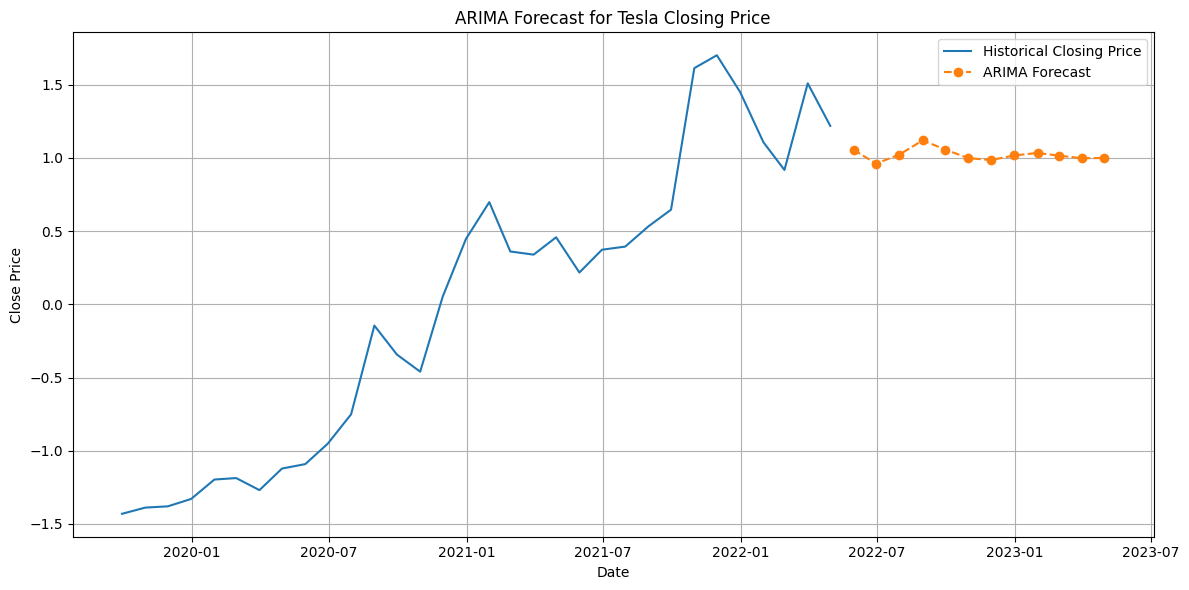

In [ ]:
# ARIMA model
# Load your cleaned data
data = pd.read_csv('/content/drive/My Drive/TSLA.csv')
# Use unscaled closing price (you must use original scale for ARIMA)
close_data = df['Close']

# Train ARIMA model (order can be tuned)
model = ARIMA(close_data, order=(5, 1, 0))  # (p=5, d=1, q=0) is a common starting point
model_fit = model.fit()

# Forecast next 12 months
forecast_steps = 12
forecast = model_fit.forecast(steps=forecast_steps)

# Create time index for future predictions
last_date = df['Date'].iloc[-1]
forecast_dates = pd.date_range(last_date, periods=forecast_steps + 1, freq='M')[1:]

# Plot actual vs forecast
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], close_data, label='Historical Closing Price')
plt.plot(forecast_dates, forecast, label='ARIMA Forecast', marker='o', linestyle='--')
plt.title('ARIMA Forecast for Tesla Closing Price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Random Forest with GridSearch Results:
Best Parameters: {'max_depth': 5, 'n_estimators': 50}
MAE: 20.37
RMSE: 30.21


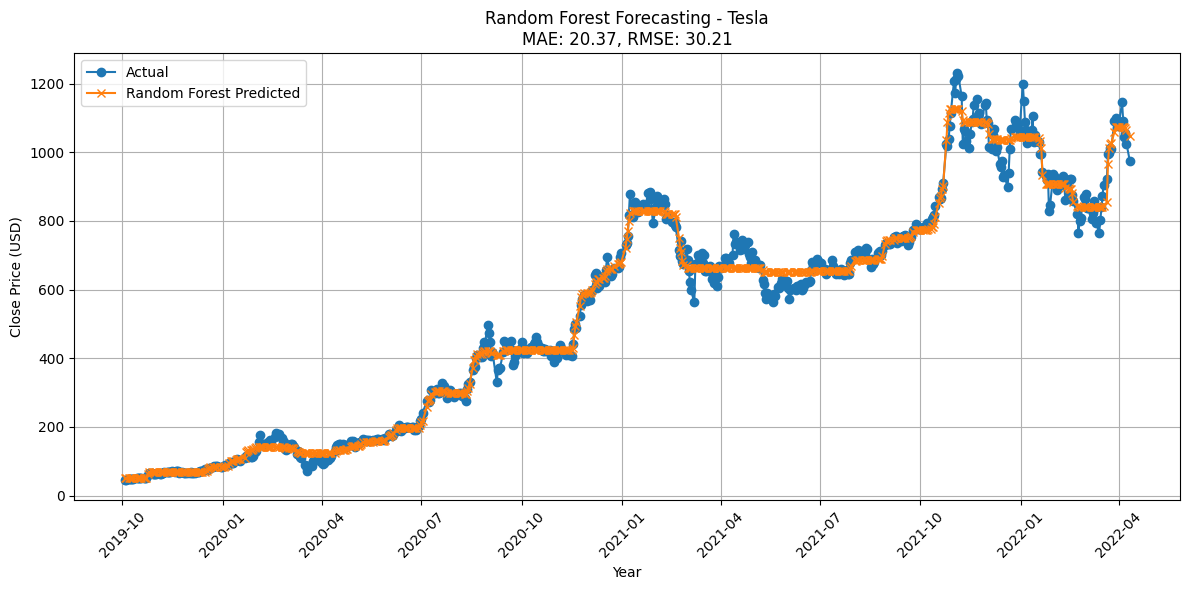

In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Load data
df = pd.read_csv('/content/drive/My Drive/TSLA.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

# Scale target (Close)
scaler = MinMaxScaler()
df['Close_Scaled'] = scaler.fit_transform(df[['Close']])

# Create supervised features
def create_supervised_data(data, window=3):
    X, y = [], []
    for i in range(window, len(data)):
        X.append(data[i-window:i])
        y.append(data[i])
    return np.array(X), np.array(y)

window_size = 3
X, y = create_supervised_data(df['Close_Scaled'].values, window=window_size)

# Flatten input shape to fit GridSearchCV expectation (1D for sklearn API)
X_flat = np.arange(len(y)).reshape(-1, 1)

# Hyperparameter tuning with GridSearch
rf_model = RandomForestRegressor()
rf_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10]
}
rf_grid_search = GridSearchCV(rf_model, rf_params, scoring='neg_mean_squared_error', cv=3)
rf_grid_search.fit(X_flat, y)

# Predict using best model
rf_best_model = rf_grid_search.best_estimator_
rf_predictions_scaled = rf_best_model.predict(X_flat)

# Inverse transform predictions
rf_predictions = scaler.inverse_transform(rf_predictions_scaled.reshape(-1, 1)).flatten()
y_actual = scaler.inverse_transform(y.reshape(-1, 1)).flatten()

# Evaluation
mae = mean_absolute_error(y_actual, rf_predictions)
rmse = np.sqrt(mean_squared_error(y_actual, rf_predictions))

print("Random Forest with GridSearch Results:")
print("Best Parameters:", rf_grid_search.best_params_)
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

# Use date values aligned with target variable
date_index = df['Date'].values[window_size:]

# Plot with actual years
plt.figure(figsize=(12, 6))
plt.plot(date_index, y_actual, label='Actual', marker='o')
plt.plot(date_index, rf_predictions, label='Random Forest Predicted', marker='x')
plt.title(f"Random Forest Forecasting - Tesla\nMAE: {mae:.2f}, RMSE: {rmse:.2f}")
plt.xlabel("Year")
plt.ylabel("Close Price (USD)")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Best Params: {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
MAE: 49.60
RMSE: 63.35


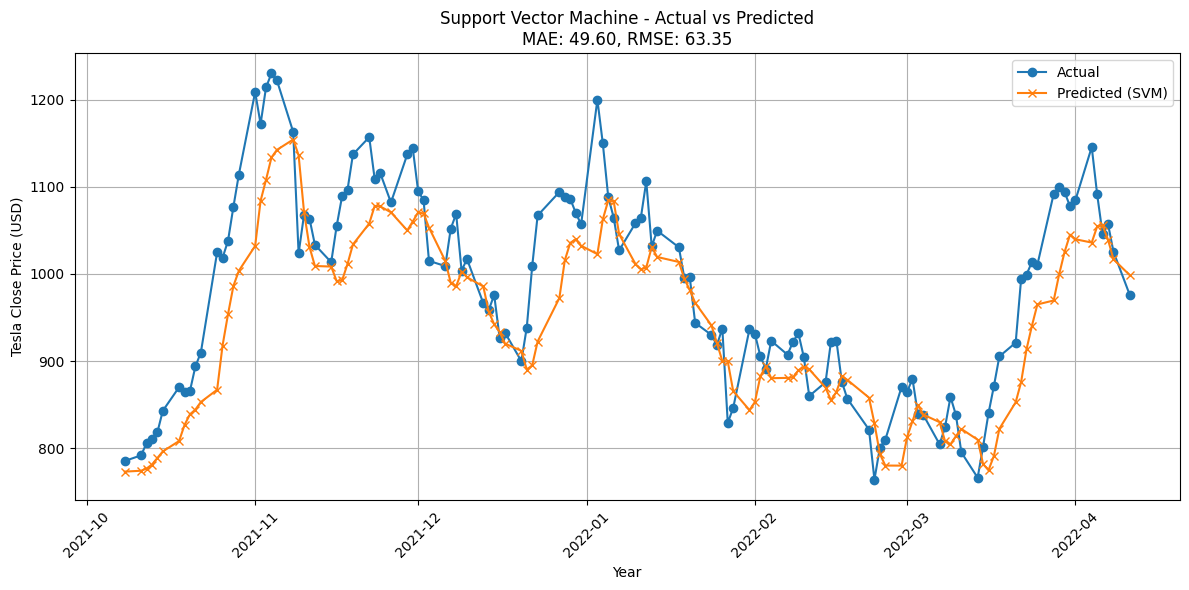

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler

# Load data
df = pd.read_csv('/content/drive/My Drive/TSLA.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

# Use only closing prices
close_prices = df['Close'].values.reshape(-1, 1)

# Scale the target (Close price)
target_scaler = MinMaxScaler()
scaled_close = target_scaler.fit_transform(close_prices).flatten()

# Create supervised dataset using sliding window
def create_supervised_data(data, window=3):
    X, y = [], []
    for i in range(window, len(data)):
        X.append(data[i-window:i])
        y.append(data[i])
    return np.array(X), np.array(y)

window_size = 3
X, y = create_supervised_data(scaled_close, window=window_size)

# Split into train/test sets (no shuffle for time series)
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Scale input features
feature_scaler = MinMaxScaler()
X_train_scaled = feature_scaler.fit_transform(X_train)
X_test_scaled = feature_scaler.transform(X_test)

# Grid search with time series split
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.001, 0.01, 0.1, 1],
    'kernel': ['rbf']
}

tscv = TimeSeriesSplit(n_splits=5)
svm = SVR()
grid_search = GridSearchCV(svm, param_grid, cv=tscv, scoring='neg_mean_squared_error')
grid_search.fit(X_train_scaled, y_train)

# Best model
svm_best_model = grid_search.best_estimator_
svm_predictions_scaled = svm_best_model.predict(X_test_scaled)

# Inverse transform predictions and actual values
svm_predictions = target_scaler.inverse_transform(svm_predictions_scaled.reshape(-1, 1)).flatten()
y_test_unscaled = target_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Evaluate
mae = mean_absolute_error(y_test_unscaled, svm_predictions)
rmse = np.sqrt(mean_squared_error(y_test_unscaled, svm_predictions))

print("Best Params:", grid_search.best_params_)
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

# Create a date index aligned with y_test
date_index = df['Date'].values[window_size + split:]  # match length of y_test
# Plot Actual vs Predicted for SVM
plt.figure(figsize=(12, 6))
plt.plot(date_index, y_test_unscaled, label='Actual', marker='o')
plt.plot(date_index, svm_predictions, label='Predicted (SVM)', marker='x')
plt.title(f'Support Vector Machine - Actual vs Predicted\nMAE: {mae:.2f}, RMSE: {rmse:.2f}')
plt.xlabel('Year')
plt.ylabel('Tesla Close Price (USD)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training LSTM...
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step  
 LSTM Forecast Results
MAE  : 36.55
RMSE : 46.74


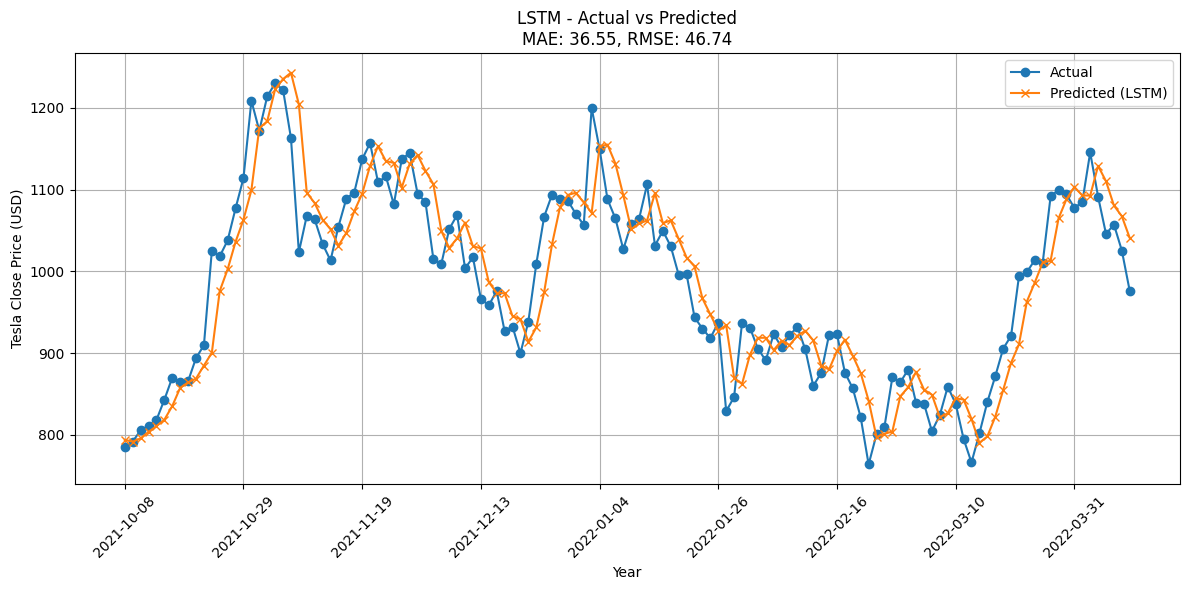

In [ ]:
#  LSTM model
#Load and Prepare Dataset
data = pd.read_csv('/content/drive/My Drive/TSLA.csv')
df = data.copy()

#Scale Only the 'Close' Column
close_scaler = MinMaxScaler()
df['Close_Scaled'] = close_scaler.fit_transform(df[['Close']])

#Create Sliding Window Sequences
def create_sequence(data, window):
    X, y = [], []
    for i in range(window, len(data)):
        X.append(data[i-window:i])
        y.append(data[i])
    return np.array(X), np.array(y)

window_size = 3
X, y = create_sequence(df['Close_Scaled'].values, window_size)

#Train-Test Split
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

#Reshape Input for LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

#Build and Train LSTM Model
model_lstm = Sequential()
model_lstm.add(LSTM(64, activation='relu', input_shape=(window_size, 1)))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer='adam', loss='mse')

print("Training LSTM...")
model_lstm.fit(X_train, y_train, epochs=100, batch_size=8, verbose=0)

# Make Predictions and Inverse Transform
pred_lstm = model_lstm.predict(X_test)
pred_lstm_unscaled = close_scaler.inverse_transform(pred_lstm)
y_test_unscaled = close_scaler.inverse_transform(y_test.reshape(-1, 1))

# Evaluation
mae = mean_absolute_error(y_test_unscaled, pred_lstm_unscaled)
rmse = np.sqrt(mean_squared_error(y_test_unscaled, pred_lstm_unscaled))
print(" LSTM Forecast Results")
print(f"MAE  : {mae:.2f}")
print(f"RMSE : {rmse:.2f}")

# Create a date index aligned with y_test
date_index = df['Date'].values[window_size + split:]  # match length of y_test
# Plot Actual vs Predicted for LSTM
plt.figure(figsize=(12, 6))
plt.plot(date_index, y_test_unscaled, label='Actual', marker='o')
plt.plot(date_index, pred_lstm_unscaled, label='Predicted (LSTM)', marker='x')
plt.title(f'LSTM - Actual vs Predicted\nMAE: {mae:.2f}, RMSE: {rmse:.2f}')
plt.xlabel('Year')
plt.ylabel('Tesla Close Price (USD)')
# Set x-ticks to show fewer labels
plt.xticks(ticks=np.arange(0, len(date_index), step=15), labels=date_index[::15], rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training Bidirectional LSTM...
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step  
 Bidirectional LSTM Forecast Results
MAE  : 36.49
RMSE : 47.28


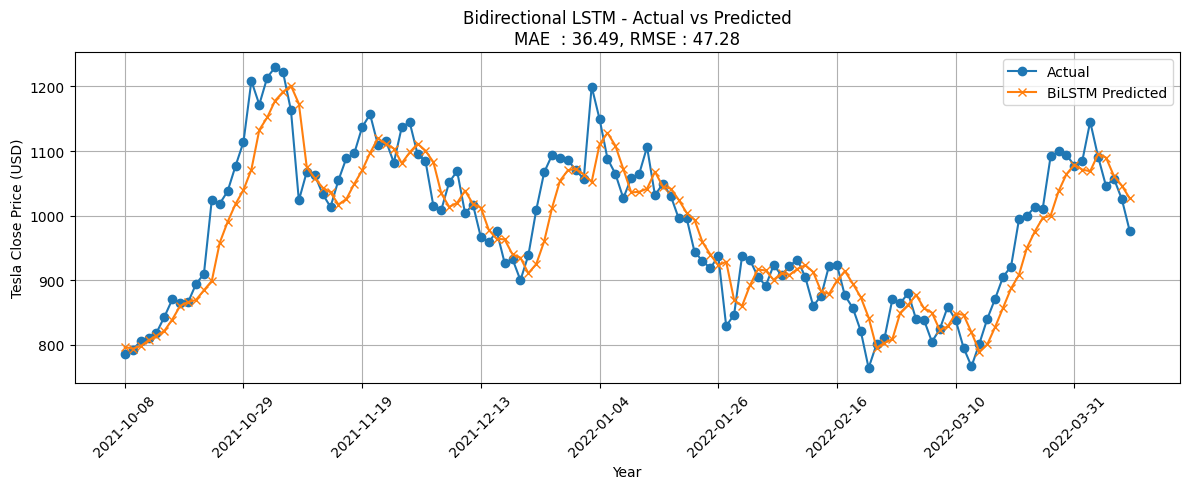

In [ ]:
# Bidirectional LSTM
#Load and Prepare Dataset
data = pd.read_csv('/content/drive/My Drive/TSLA.csv')
df = data.copy()

# Scale Only the 'Close' Column
close_scaler = MinMaxScaler()
df['Close_Scaled'] = close_scaler.fit_transform(df[['Close']])

#Create Sliding Window Sequences
def create_sequence(data, window):
    X, y = [], []
    for i in range(window, len(data)):
        X.append(data[i-window:i])
        y.append(data[i])
    return np.array(X), np.array(y)

window_size = 3
X, y = create_sequence(df['Close_Scaled'].values, window=window_size)

# Train-Test Split
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Reshape Input for LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Build and Train model
model_bilstm = Sequential()
model_bilstm.add(Bidirectional(LSTM(64, activation='relu'), input_shape=(window_size, 1)))
model_bilstm.add(Dense(1))
model_bilstm.compile(optimizer='adam', loss='mse')

print("Training Bidirectional LSTM...")
model_bilstm.fit(X_train, y_train, epochs=100, batch_size=8, verbose=0)

# Make Predictions and Inverse Transform
pred_bilstm = model_bilstm.predict(X_test)
pred_bilstm_unscaled = close_scaler.inverse_transform(pred_bilstm)
y_test_unscaled = close_scaler.inverse_transform(y_test.reshape(-1, 1))

# Evaluation
mae_bilstm = mean_absolute_error(y_test_unscaled, pred_bilstm_unscaled)
rmse_bilstm = np.sqrt(mean_squared_error(y_test_unscaled, pred_bilstm_unscaled))

print(" Bidirectional LSTM Forecast Results")
print(f"MAE  : {mae_bilstm:.2f}")
print(f"RMSE : {rmse_bilstm:.2f}")

# Create a date index aligned with y_test
date_index = df['Date'].values[window_size + split:]  # match length of y_test

# Plot Actual vs Predicted
plt.figure(figsize=(12, 5))
plt.plot(y_test_unscaled, label='Actual', marker='o')
plt.xticks(ticks=np.arange(0, len(date_index), step=15), labels=date_index[::15], rotation=45)
plt.plot(pred_bilstm_unscaled, label='BiLSTM Predicted', marker='x')
plt.title(f'Bidirectional LSTM - Actual vs Predicted\nMAE  : {mae_bilstm:.2f}, RMSE : {rmse_bilstm:.2f}')
plt.xlabel('Year')
plt.ylabel('Tesla Close Price (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Future Closing Price Predictions:
[1074.7437 1075.5151 1076.5825 1078.4451 1080.7224 1083.2045 1085.7771
 1088.3788 1090.9774 1093.5582]


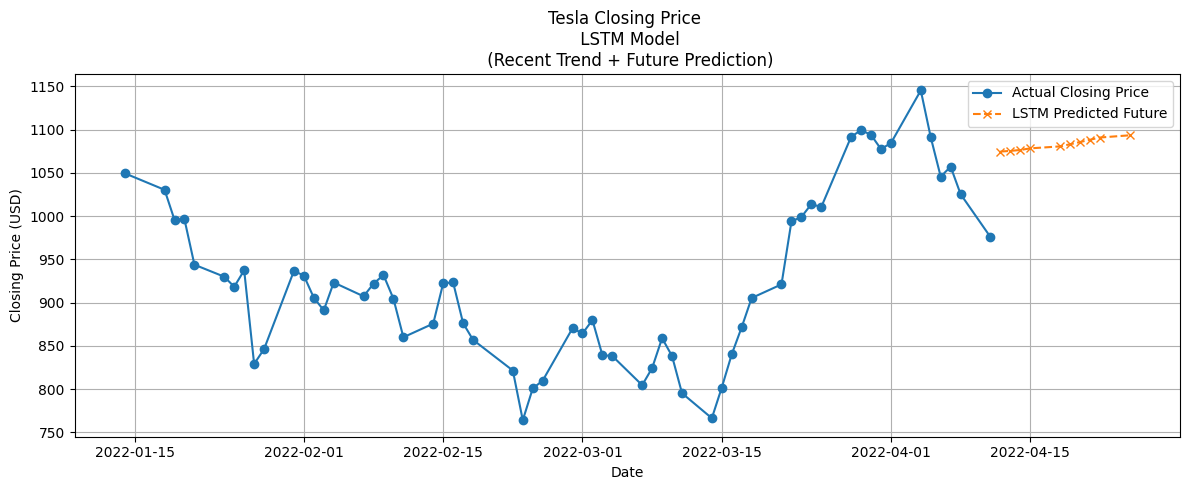

In [ ]:
# Ensure date column is datetime
df['Date'] = pd.to_datetime(df['Date'])

# Step 1: Scale the data
scaler = MinMaxScaler()
scaled_close = scaler.fit_transform(df['Close'].values.reshape(-1, 1))

# Step 2: Prepare sequences
window_size = 60
X, y = [], []

for i in range(window_size, len(scaled_close)):
    X.append(scaled_close[i - window_size:i])
    y.append(scaled_close[i])

X, y = np.array(X), np.array(y)
X = X.reshape((X.shape[0], X.shape[1], 1))  # reshape for LSTM

# Step 4: Predict future prices
def predict_future_lstm(model, last_data, num_predictions, window_size, scaler):
    predictions = []
    current_data = last_data[-window_size:].reshape(1, window_size, 1)

    for _ in range(num_predictions):
        next_pred = model.predict(current_data, verbose=0)[0, 0]
        predictions.append(next_pred)
        current_data = np.append(current_data[:, 1:, :], [[[next_pred]]], axis=1)

    predictions_unscaled = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
    return predictions_unscaled.flatten()

last_data = scaled_close[-window_size:]
num_future_predictions = 10
future_prices = predict_future_lstm(model, last_data, num_future_predictions, window_size, scaler)

# Step 5: Prepare dates
last_date = df['Date'].iloc[-1]
future_dates = pd.bdate_range(start=last_date + pd.Timedelta(days=1), periods=num_future_predictions)

# Make future predictions
future_prices = predict_future_lstm(model, last_data, num_predictions, window_size, scaler)

# Print the predicted future closing prices
print("Future Closing Price Predictions:")
print(future_prices)

# Limit to last 60 actual dates
visible_actual_dates = df['Date'].iloc[-60:]
visible_actual_prices = df['Close'].iloc[-60:]

# Plot with limited x-axis range
plt.figure(figsize=(12, 5))
plt.plot(visible_actual_dates, visible_actual_prices, label='Actual Closing Price', marker='o')
plt.plot(future_dates, future_prices, label='LSTM Predicted Future', marker='x', linestyle='--')

plt.title('Tesla Closing Price \n LSTM Model\n (Recent Trend + Future Prediction)')
plt.xlabel('Date')
plt.ylabel('Closing Price (USD)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


Future Closing Price Predictions:
[975.32005942 952.79218884 932.94303271 919.39397882 903.40644315
 889.09361265 876.14881486 863.55581309 851.88877862 840.9679752 ]


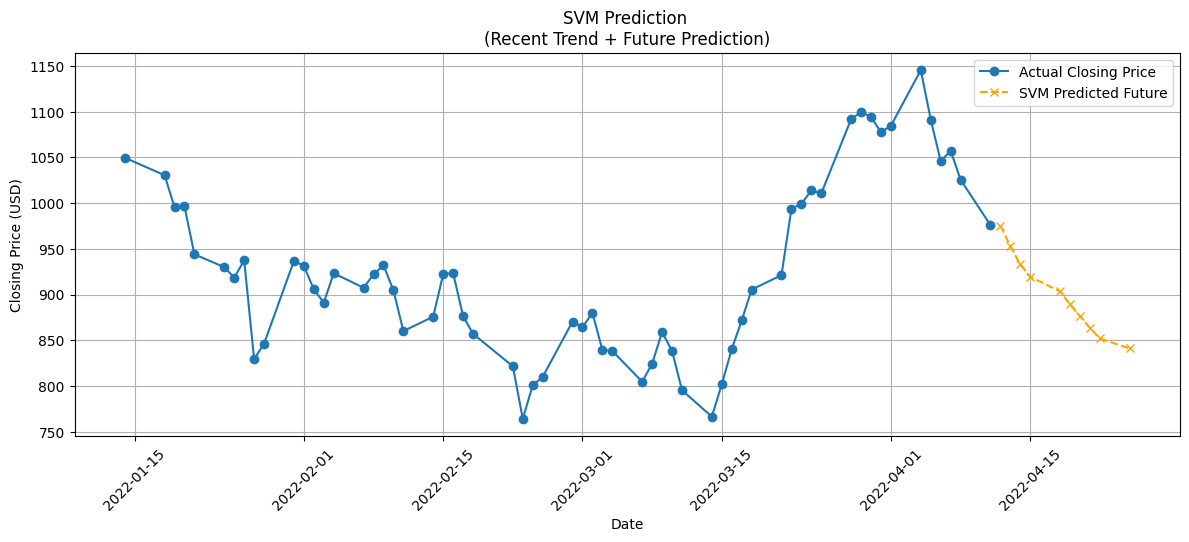

In [ ]:
# --- Predict the next 10 future closing prices using your trained SVM ---
num_future_predictions = 10
future_preds_scaled = []

# Start with the last known window from scaled_close
last_window = scaled_close[-window_size:].copy()

for _ in range(num_future_predictions):
    input_scaled = feature_scaler.transform(last_window.reshape(1, -1))
    pred_scaled = svm_best_model.predict(input_scaled)[0]
    future_preds_scaled.append(pred_scaled)
    last_window = np.append(last_window[1:], pred_scaled)

# Inverse transform to get actual price values
future_predictions = target_scaler.inverse_transform(np.array(future_preds_scaled).reshape(-1, 1)).flatten()

# Print the predicted future closing prices
print("Future Closing Price Predictions:")
print(future_predictions)

# Limit to last 60 actual dates and prices
visible_actual_dates = df['Date'].iloc[-60:]
visible_actual_prices = df['Close'].iloc[-60:]

# Plot recent actuals + future predictions
plt.figure(figsize=(12, 5))
plt.plot(visible_actual_dates, visible_actual_prices, label='Actual Closing Price', marker='o')
plt.plot(future_dates, future_predictions, label='SVM Predicted Future', marker='x', linestyle='--', color='orange')

plt.title('SVM Prediction \n(Recent Trend + Future Prediction)')
plt.xlabel('Date')
plt.ylabel('Closing Price (USD)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

Future Closing Price Predictions:
[981.22994266 982.84207566 983.04675766 983.47289999 983.92444585
 984.36631558 984.80726326 985.24769612 985.68731443 986.12613038]


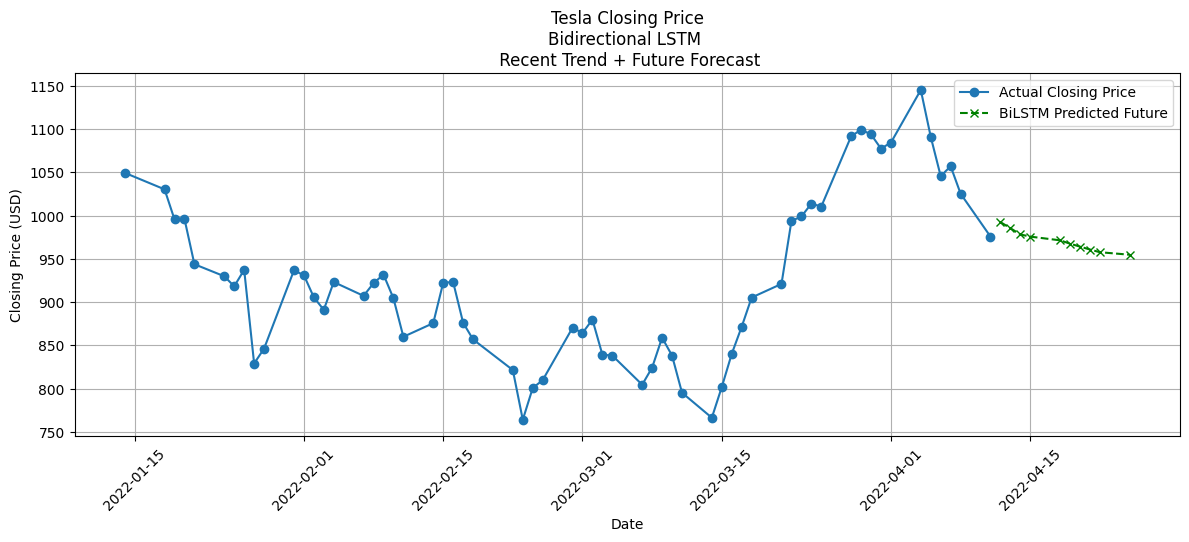

In [ ]:
# --- Predict future prices using recursive forecasting ---
def predict_future_bilstm(model, last_data, num_predictions, window_size, scaler):
    predictions = []
    current_window = last_data[-window_size:].copy()

    for _ in range(num_predictions):
        input_seq = current_window.reshape(1, window_size, 1)
        pred_scaled = model.predict(input_seq, verbose=0)[0, 0]
        predictions.append(pred_scaled)
        current_window = np.append(current_window[1:], pred_scaled)

    predictions_unscaled = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
    return predictions_unscaled.flatten()

# Get the last available window from the scaled Close data
last_scaled_window = df['Close_Scaled'].values[-window_size:]

# Number of days to predict
num_future_predictions = 10

# Get future predicted prices
future_bilstm_prices = predict_future_bilstm(
    model_bilstm, last_scaled_window, num_future_predictions, window_size, close_scaler)

# Generate 10 future business dates after the last known date
df['Date'] = pd.to_datetime(df['Date'])  # Ensure 'Date' is datetime
last_date = df['Date'].iloc[-1]
future_dates = pd.bdate_range(start=last_date + pd.Timedelta(days=1), periods=num_future_predictions)

# Last 60 actual points
visible_actual_dates = df['Date'].iloc[-60:]
visible_actual_prices = df['Close'].iloc[-60:]

# Inverse transform to get actual price values
future_predictions = target_scaler.inverse_transform(np.array(future_preds_scaled).reshape(-1, 1)).flatten()

# Print the predicted future closing prices
print("Future Closing Price Predictions:")
print(future_predictions)

# Plot actual + predicted
plt.figure(figsize=(12, 5))
plt.plot(visible_actual_dates, visible_actual_prices, label='Actual Closing Price', marker='o')
plt.plot(future_dates, future_bilstm_prices, label='BiLSTM Predicted Future', marker='x', linestyle='--', color='green')

plt.title('Tesla Closing Price\nBidirectional LSTM \n Recent Trend + Future Forecast')
plt.xlabel('Date')
plt.ylabel('Closing Price (USD)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()


Future Closing Price Predictions:
[981.22994266 982.84207566 983.04675766 983.47289999 983.92444585
 984.36631558 984.80726326 985.24769612 985.68731443 986.12613038]


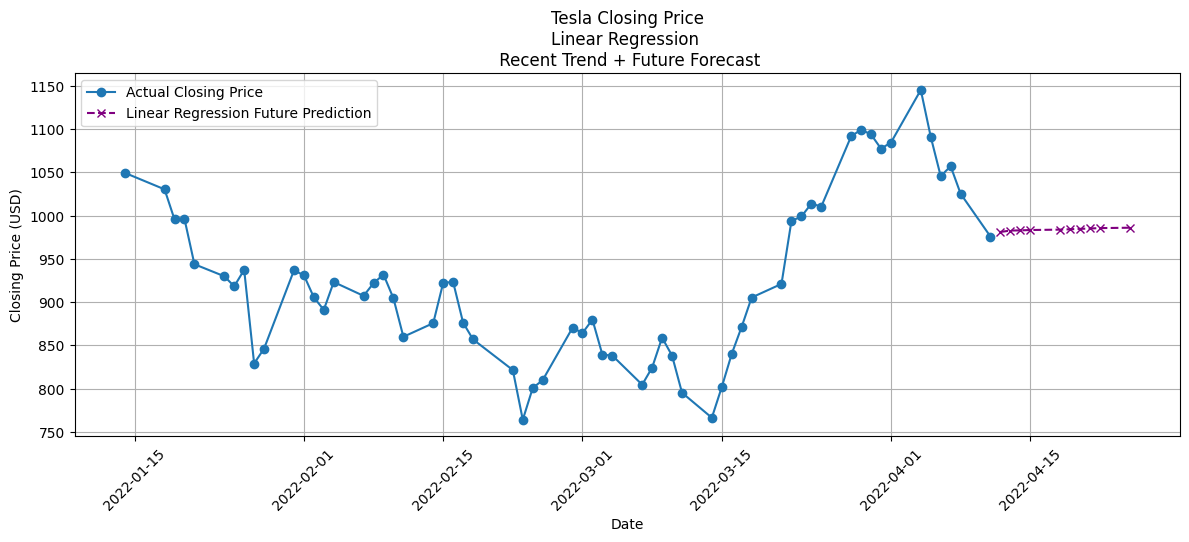

In [ ]:
# --- Predict next 10 future closing prices using recursive forecasting ---
num_future_predictions = 10
future_preds_scaled = []

# Start with the last known window from the scaled data
last_window = df['Close_Scaled'].values[-window_size:].copy()

for _ in range(num_future_predictions):
    input_seq = last_window.reshape(1, -1)  # shape (1, window_size)
    next_pred_scaled = model_lr.predict(input_seq)[0]
    future_preds_scaled.append(next_pred_scaled)
    last_window = np.append(last_window[1:], next_pred_scaled)  # slide the window

# Inverse scale the predictions to get actual closing prices
future_lr_predictions = scaler.inverse_transform(np.array(future_preds_scaled).reshape(-1, 1)).flatten()

# Generate 10 future business dates starting after the last known date
last_date = df['Date'].iloc[-1]
future_dates = pd.bdate_range(start=last_date + pd.Timedelta(days=1), periods=num_future_predictions)

# Limit to last 60 actual dates for cleaner plot
visible_actual_dates = df['Date'].iloc[-60:]
visible_actual_prices = df['Close'].iloc[-60:]

# Inverse transform to get actual price values
future_predictions = target_scaler.inverse_transform(np.array(future_preds_scaled).reshape(-1, 1)).flatten()

# Print the predicted future closing prices
print("Future Closing Price Predictions:")
print(future_predictions)

# Plot the recent actuals and future predictions
plt.figure(figsize=(12, 5))
plt.plot(visible_actual_dates, visible_actual_prices, label='Actual Closing Price', marker='o')
plt.plot(future_dates, future_lr_predictions, label='Linear Regression Future Prediction', marker='x', linestyle='--', color='purple')

plt.title('Tesla Closing Price\nLinear Regression \n Recent Trend + Future Forecast')
plt.xlabel('Date')
plt.ylabel('Closing Price (USD)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()



In [ ]:
!git clone https://github.com/smagen12/Project_Tesla-.git
%cd Project_Tesla-


Cloning into 'Project_Tesla-'...
remote: Enumerating objects: 14, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 14 (delta 3), reused 4 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (14/14), 672.13 KiB | 11.79 MiB/s, done.
Resolving deltas: 100% (3/3), done.
/content/Project_Tesla-/Project_Tesla-


In [ ]:
!rm -rf *  # ⚠️ Removes all files and folders in the repo directory


In [ ]:
!cp /content/Tesla_project.ipynb .


cp: cannot stat '/content/Tesla_project.ipynb': No such file or directory
